# Example counterfactual explanation generation workflow

## train GNN

In [1]:
# import torch
# from torch.optim import AdamW
# from models import get_model
# from utils import get_loader, train, test, evaluation
# loader_name = 'Neighbor'
# hidden_size = 128
# model_name = 'RGCN'
# learning_rate = 0.002
# epoch_num = 200
# data_path = 'data/processed/data_homo.pt'
# model_save_path = "models/"
# # Set up the device for training
# #device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
# num_relations = 5
# ## DATA LOADING AND SAMPLING
# data = torch.load(data_path)
# edge_type = data.edge_attr[:, 1:].argmax(dim=1)
# # print(f"HeteroData object: {data}")
# train_loader, val_loader, test_loader = get_loader(data, loader_name)  # Initialise Dataloaders
#
# ## MODELLING
# num_features = data.x.shape[1]
# num_classes = data.y.shape[1]
# model = get_model(model_name, num_features, hidden_size, num_classes, device)
# optimizer = AdamW(model.parameters(), lr=learning_rate)
#

In [2]:
# ## TRAINING
# for epoch in range(1, epoch_num + 1):
#     loss = train(model_name, model, train_loader, optimizer, device)
#     val_acc = test(model_name, model, val_loader, device)
#     test_acc = test(model_name, model, test_loader, device)
#     print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, ',
#           f'Val: {val_acc:.4f} Test: {test_acc:.4f}')
#
# ## EVALUATION & SAVING
# results = evaluation(model_name, model, test_loader, device)
# print(results)

In [3]:
import torch
import torch.nn.functional as F
from torch_geometric.loader import HGTLoader
from torch_geometric.nn import HGTConv, Linear
from utils import evaluation
import pandas as pd

data = torch.load('data/processed/data_hetero.pt')
# print(f"Data objects: {data}")
kwargs = {'batch_size': 64, 'num_workers': 0, 'persistent_workers': False}
# Creating heterogeneous graph training, validation, and test loaders
train_loader = HGTLoader(data, num_samples={'node': [512] * 2}, shuffle=True,
                         input_nodes=('node', data['node'].train_mask), **kwargs)
val_loader = HGTLoader(data, num_samples={'node': [512] * 2},
                       input_nodes=('node', data['node'].val_mask), **kwargs)
test_loader = HGTLoader(data, num_samples={'node': [512] * 2},
                        input_nodes=('node', data['node'].test_mask), **kwargs)


class HGT(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels, num_heads, num_layers):
        super().__init__()

        self.lin_dict = torch.nn.ModuleDict()
        for node_type in data.node_types:
            self.lin_dict[node_type] = Linear(-1, hidden_channels)

        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            conv = HGTConv(hidden_channels, hidden_channels, data.metadata(),
                           num_heads)
            self.convs.append(conv)

        self.lin = Linear(hidden_channels, out_channels)

    def forward(self, x_dict, edge_index_dict):
        x_dict = {
            node_type: self.lin_dict[node_type](x).relu_()
            for node_type, x in x_dict.items()
        }

        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict)

        return self.lin(x_dict['node'])

In [4]:
model_name = "HGT"
model = HGT(hidden_channels=64, out_channels=6, num_heads=2, num_layers=2)
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
data, model = data.to(device), model.to(device)
model.load_state_dict(torch.load('HGT_HGTLoader.pth'))
results = evaluation(model_name, model, test_loader, device)
print(results)

              MSE   RMSE    MAE     R2
office      0.002  0.047  0.031  0.928
sustenance  0.002  0.040  0.026  0.950
transport   0.003  0.053  0.036  0.928
retail      0.004  0.060  0.041  0.884
leisure     0.005  0.070  0.047  0.838
residence   0.004  0.067  0.045  0.877


In [5]:
model(data.x_dict, data.edge_index_dict)

tensor([[ 0.0806,  0.2003,  0.5206,  0.2012,  0.6066,  0.5111],
        [ 0.8377,  0.7975,  0.7433,  0.4149,  0.7355,  0.3248],
        [ 0.6670,  0.5601,  0.8422,  0.3416,  0.4985,  0.1744],
        ...,
        [ 0.1083,  0.1233,  0.1377,  0.4121,  0.2083,  0.4658],
        [ 0.2508,  0.2020,  0.2785,  0.5319,  0.0566,  0.6261],
        [ 0.0329,  0.0317,  0.0732,  0.0411, -0.0045,  0.6704]],
       grad_fn=<AddmmBackward0>)

In [6]:
print(data.x_dict['node'].shape)
print(data.edge_index_dict.keys())

torch.Size([4236, 67])
dict_keys([('node', 'type0', 'node'), ('node', 'type1', 'node'), ('node', 'type2', 'node'), ('node', 'type3', 'node'), ('node', 'type4', 'node')])


In [7]:
# get all edge index
data_edge_index = None
prev_edge_index = None
# store edge types according to edge index
edge_type_store = {}
for i, key in enumerate(data.edge_index_dict.keys()):
    data_edge_index = data.edge_index_dict[key]
    for item in data.edge_index_dict[key].t():
        edge_type_store[f"{item[0]},{item[1]}"] = i
    if prev_edge_index is not None:
        data_edge_index = torch.cat((data_edge_index, prev_edge_index), dim=1)
    prev_edge_index = data_edge_index
print(data_edge_index.shape)

# get data_x
data_x = data.x_dict['node']
print(data_x.shape)

torch.Size([2, 42223])
torch.Size([4236, 67])


In [8]:
data_x_node_feat = data_x[:, :64]
print(data_x_node_feat.shape)
data_x_node_type = data_x[:, 64:]
print(data_x_node_type.shape)

torch.Size([4236, 64])
torch.Size([4236, 3])


In [9]:
print(data_x_node_type)
print(torch.unique(data_x_node_type, dim=0))

tensor([[ 1.9487, -1.7212, -0.2143],
        [ 1.9487, -1.7212, -0.2143],
        [ 1.9487, -1.7212, -0.2143],
        ...,
        [-0.5132, -1.7212,  4.6663],
        [-0.5132, -1.7212,  4.6663],
        [-0.5132, -1.7212,  4.6663]])
tensor([[-0.5132, -1.7212,  4.6663],
        [-0.5132,  0.5810, -0.2143],
        [ 1.9487, -1.7212, -0.2143]])


In [10]:
import numpy as np
edge_t0 = torch.unique(data_x_node_type, dim=0)[0]
edge_t1 = torch.unique(data_x_node_type, dim=0)[1]
edge_t2 = torch.unique(data_x_node_type, dim=0)[2]
data_x_node_type_transformed = []
for item in data_x_node_type:
    if (item==edge_t0).all():
        data_x_node_type_transformed.append(0)
    if (item==edge_t1).all():
        data_x_node_type_transformed.append(1)
    if (item==edge_t2).all():
        data_x_node_type_transformed.append(2)
print(np.unique(data_x_node_type_transformed))
print(len(data_x_node_type_transformed))

[0 1 2]
4236


## Compute Counterfactuals

In [11]:
from torch_geometric.utils import k_hop_subgraph
from torch.nn.functional import cosine_similarity

# construct neighbouring graph
def get_1hop_complete_subgraph(data_edge_index, node_idx):
    """
    from the input graph, specify a node index, get 1-hop neighbourhood of the node,
    both from source to target (input node as target)
    and from target to source (input node as source)
    :param data: torch geometric data, full dataset
    :param node_idx: int, node index
    :return: tensor list of neighbouring node indices including node index, tensor list of edges
    """
    stt_subgraph_info = k_hop_subgraph(node_idx=node_idx, num_hops=1, edge_index=data_edge_index,
                                       relabel_nodes=False, flow="source_to_target")
    tts_subgraph_info = k_hop_subgraph(node_idx=node_idx, num_hops=1, edge_index=data_edge_index,
                                       relabel_nodes=False, flow="target_to_source")
    stt_nodes = stt_subgraph_info[0]
    tts_nodes = tts_subgraph_info[0]
    subg_nodes = torch.unique(torch.cat((stt_nodes, tts_nodes)))
    stt_edges = stt_subgraph_info[1].t()
    tts_edges = tts_subgraph_info[1].t()
    subg_edges = torch.unique(torch.cat((stt_edges, tts_edges), dim=0), dim=0)
    return subg_nodes, subg_edges

In [12]:
def graph_dissimilarity(data_x, data_x_node_type_transformed, edge_type_store, node_idx_1, subg_nodes_1, subg_edges_1, subg_nodes_2, subg_edges_2,
                        lamb_node=1, lamb_node_type=1, lamb_e=1, lamb_g=1):
    data_x_node_feat = data_x[:, :64]
    node_feat_dissim = node_features_dissimilarity(data_x_node_feat, node_idx_1, subg_nodes_2)
    node_type_dissim = node_type_dissimilarity(data_x_node_type_transformed, subg_nodes_1, subg_nodes_2)
    edge_feat_dissim = edge_features_dissimilarity(edge_type_store, subg_edges_1, subg_edges_2)
    graph_structure_dissim = graph_structure_dissimilarity(subg_edges_1, subg_edges_2)
    return lamb_node * node_feat_dissim + lamb_node_type*node_type_dissim + lamb_e * edge_feat_dissim + lamb_g * graph_structure_dissim, [node_feat_dissim, node_type_dissim, edge_feat_dissim, graph_structure_dissim]


# node features dissimilarity ranged [0, 1]:
# normalised L2 distance + cosine distance, between the input node 1 and the neighbouring nodes of node 2
def node_features_dissimilarity(data_x, node_idx_1, sug_nodes_2):
    feat1 = data_x[node_idx_1].view(1, -1)
    feat2 = data_x[sug_nodes_2]
    return (torch.norm(feat2 - feat1, p=2, dim=1).mean() / (
            (torch.norm(feat2, p=2, dim=1).mean()) + torch.norm(feat1, p=2)) + (
                    1 - (cosine_similarity(feat1, feat2).mean() + 1) / 2)) / 2

# Multiset Jaccard distance
def node_type_dissimilarity(data_x_node_type_transformed, subg_nodes_1, subg_nodes_2):
    # types_1 = np.array(data_x_node_type_transformed)[[subg_nodes_1]]
    # types_2 = np.array(data_x_node_type_transformed)[[subg_nodes_2]]
    # dissim_type = 0
    # for i in types_1.flatten():
    #     for j in types_2.flatten():
    #         dissim_type += int(i!=j)
    # return dissim_type / (len(types_1.flatten()) * len(types_2.flatten()))
    dict_a = get_node_type_count(data_x_node_type_transformed, subg_nodes_1)
    dict_b = get_node_type_count(data_x_node_type_transformed, subg_nodes_2)

    numerator = 0
    denominator = 0

    for i in [0, 1, 2]:
        try:
            count_a = dict_a[i]
        except:
            count_a = 0
        try:
            count_b = dict_b[i]
        except:
            count_b = 0
        numerator += min(count_a, count_b)
        denominator += max(count_a, count_b)
    return 1-numerator/denominator


def get_node_type_count(data_x_node_type_transformed, subg_nodes):
    a = np.array(data_x_node_type_transformed)[[subg_nodes]].flatten()
    unique_a = torch.unique(torch.from_numpy(a), return_counts=True)

    dict_a = {}
    for i, type in enumerate(unique_a[0]):
        dict_a[int(type)] = int(unique_a[1][i])
    return dict_a


    # edge features dissimilarity ranged [0, 1]:
def edge_features_dissimilarity(edge_idx_store, subg_edges_1, subg_edges_2):
    idxs1 = get_edge_type(edge_idx_store, subg_edges_1)
    idxs2 = get_edge_type(edge_idx_store, subg_edges_2)
    return (idxs1.mean() - idxs2.mean()).abs() / 4

def get_edge_type(edge_type_store, subg_edges):
    idxs = []
    for item in subg_edges:
        #print(f"{item[0]},{item[1]}")
        idxs.append(edge_type_store[f"{item[0]},{item[1]}"])
    return torch.Tensor(idxs).to(torch.float)

# graph structure dissimilarity
def graph_structure_dissimilarity(subg_edges_1, subg_edges_2):
    return abs(len(subg_edges_1) - len(subg_edges_2)) / max(len(subg_edges_1), len(subg_edges_2))

In [13]:
def compute_counterfactual(node_idx, target_prediction, predictions, data_edge_index, data_x, edge_type_store, data_x_node_type_transformed, mixed_idxs=None):
    """
    compute one counterfactual for node indicated by node_idx
    :param node_idx: int
    :param predictions: predictions, either regression or classification
    :param target_prediction
    :param data
    :return: counterfactual node, counterfactual subgraph, input subgraph, graph dissimilarity with input graph
    """
    if target_prediction == "mixed":
        candidate_ces_idxs = mixed_idxs
    else:
        candidate_ces_idxs = torch.where(predictions==target_prediction)[0]
    explainee_sgraph = get_1hop_complete_subgraph(data_edge_index, node_idx)
    optimal_ce_node = None
    optimal_ce_sgraph = None
    optimal_ce_dissimilarity = 100
    optimal_ce_dissimilarities = None
    for idx in candidate_ces_idxs:
        candidate_ce_sgraph = get_1hop_complete_subgraph(data_edge_index, int(idx))
        this_ce_dissimilarity, this_dissimilarities = graph_dissimilarity(data_x, data_x_node_type_transformed, edge_type_store, node_idx, explainee_sgraph[0], explainee_sgraph[1], candidate_ce_sgraph[0], candidate_ce_sgraph[1])
        if this_ce_dissimilarity <= optimal_ce_dissimilarity:
            optimal_ce_dissimilarity = this_ce_dissimilarity
            optimal_ce_node = idx
            optimal_ce_sgraph = candidate_ce_sgraph
            optimal_ce_dissimilarities = this_dissimilarities
    return optimal_ce_node, optimal_ce_sgraph, explainee_sgraph, optimal_ce_dissimilarity, optimal_ce_dissimilarities

## Example usage

In [14]:
# get all predictions and transform to classification labels
y_pred = model(data.x_dict, data.edge_index_dict)
y_pred_class = torch.argmax(y_pred, dim=1)

# construct a dict to store index for edge index
#edge_idx_store = {}
# for i, item in enumerate(data_edge_index.t()):
#     edge_idx_store[f"{item[0]},{item[1]}"] = i
edge_idx_store = edge_type_store

In [15]:
print(torch.where(y_pred_class==0))

(tensor([   1,   46,   48,   51,   67,   88,   89,   96,  103,  121,  123,  129,
         153,  174, 1000, 1090, 1436, 1520, 1573, 1652, 1665, 1677, 2016, 2056,
        2220, 2249, 2250, 2266, 2267, 2268, 2273, 2755, 2756, 2898, 3163, 3167,
        3332, 3333, 3534, 3637, 3671, 3672, 3726, 3918, 4032, 4033, 4051, 4052,
        4058, 4105, 4146, 4159, 4165, 4188]),)


In [76]:
# want to explain the prediction result for node
node_idx = 2220
print("original prediction: class", int(y_pred_class[node_idx]))

original prediction: class 0


In [247]:
# want to find counterfactual explanation for class 5
target_prediction = 5
optimal_ce_node, optimal_ce_sgraph, explainee_sgraph, optimal_ce_dissimilarity, optimal_ce_dissimilarities = compute_counterfactual(node_idx=node_idx, target_prediction=target_prediction, predictions=y_pred_class, data_edge_index=data_edge_index, data_x=data_x, data_x_node_type_transformed=data_x_node_type_transformed, edge_type_store=edge_type_store)

In [248]:
# print out counterfactual node information
print(optimal_ce_node, y_pred_class[optimal_ce_node], optimal_ce_dissimilarity, optimal_ce_dissimilarities)

tensor(3485) tensor(5) tensor(0.5576) [tensor(0.0420), 0.4551282051282051, tensor(0.0480), 0.0125]


In [249]:
# print out counterfactual graph information: classification results, to examine whether they are all in the same class
print(y_pred_class[optimal_ce_sgraph[0]])

tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5])


In [250]:
print(optimal_ce_sgraph[0].shape)

torch.Size([13])


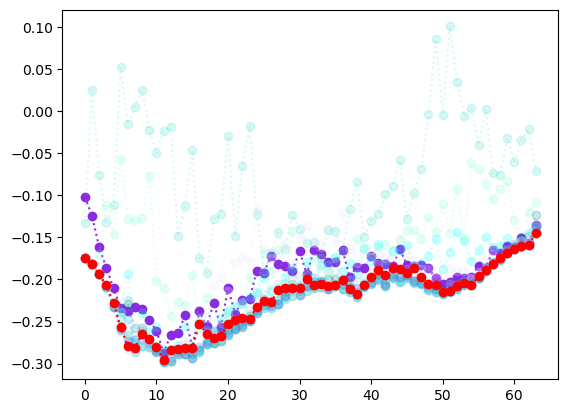

In [251]:
# plot the node features of explainee node and the nodes in the counterfactual graph:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
horizontal = range(len(data_x_node_feat[node_idx]))
ax.plot(horizontal, data_x_node_feat[optimal_ce_node], 'o:', color="blueviolet")
colors = ["aquamarine", "turquoise", "lightseagreen", "mediumturquoise", "paleturquoise", "teal", "aqua", "powderblue", "deepskyblue", "skyblue", "dodgerblue", "royalblue", "lavender", "slateblue", "lightsteelblue", "blue", "darkblue", "cornflowerblue", "lightskyblue", "cadetblue"]
for i, item in enumerate(optimal_ce_sgraph[0]):
    if int(item) == int(optimal_ce_node):
        continue
    ax.plot(horizontal, data_x_node_feat[item], 'o:', color=colors[i], alpha=0.2)
ax.plot(horizontal, data_x_node_feat[node_idx], 'or:')

## Example usage for computing counterfactuals for changing to mixed class

In [16]:
import numpy as np
import pandas as pd

def shannon_diversity_index(row):
    data = row[row > 0]
    probabilities = data / data.sum()
    return -np.sum(probabilities * np.log(probabilities))

In [17]:
# predicted labels df
label_columns_list = ['office', 'sustenance', 'transport', 'retail', 'leisure', 'residence']
y_pred = model(data.x_dict, data.edge_index_dict)
pred_df = pd.DataFrame(data=y_pred.detach().numpy(), columns=label_columns_list)
pred_df_shannon = pred_df[label_columns_list].apply(shannon_diversity_index, axis=1)
mixed_idxs = list(pred_df_shannon[pred_df_shannon>pred_df_shannon.quantile(0.8)].index)

In [18]:
# specify target class to "mixed", and specify mixed_idxs attribute, to get counterfactuals.
target_prediction = "mixed"
# optimal_ce_node, optimal_ce_sgraph, explainee_sgraph, optimal_ce_dissimilarity, optimal_ce_dissimilarities = compute_counterfactual(node_idx=0, target_prediction=target_prediction, predictions=y_pred_class, data_edge_index=data_edge_index, data_x=data_x, data_x_node_type_transformed=data_x_node_type_transformed, edge_type_store=edge_type_store, mixed_idxs=mixed_idxs)

### Example Analysis

In [19]:
# want to investigate the importance between node features, edge types, and graph structure, when changing from class 0 to mixed class.
input_idxs_with_non_mixed_class_0_label = list([int(i) for i in torch.where(y_pred_class==5)[0] if i not in mixed_idxs])
print(input_idxs_with_non_mixed_class_0_label)

[32, 149, 201, 202, 203, 204, 205, 206, 208, 209, 210, 211, 218, 219, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 235, 236, 237, 238, 239, 240, 242, 243, 244, 245, 246, 247, 248, 249, 251, 252, 253, 254, 257, 258, 259, 260, 266, 267, 277, 278, 279, 280, 281, 282, 283, 284, 285, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 322, 323, 324, 325, 326, 327, 332, 333, 334, 337, 338, 339, 340, 341, 343, 345, 348, 349, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 383, 385, 386, 387, 388, 390, 391, 392, 395, 399, 400, 401, 402, 406, 407, 408, 410, 411, 412, 413, 414, 415, 416, 417, 418, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 437, 439, 441, 443, 444, 445, 446, 447, 450, 451, 454, 455, 456, 457, 458, 459, 460, 461, 

In [256]:
dissimilarities = []
for idx in input_idxs_with_non_mixed_class_0_label:
    optimal_ce_node, optimal_ce_sgraph, explainee_sgraph, optimal_ce_dissimilarity, optimal_ce_dissimilarities = compute_counterfactual(node_idx=idx, target_prediction=target_prediction, predictions=y_pred_class, data_edge_index=data_edge_index, data_x=data_x, data_x_node_type_transformed=data_x_node_type_transformed, edge_type_store=edge_type_store, mixed_idxs=mixed_idxs)
    dissimilarities.append(optimal_ce_dissimilarities)
dissimilarities_tensor = torch.Tensor(dissimilarities)
# print(dissimilarities_tensor)

In [257]:
print(f"changing from class 0 to mixed neighbourhood, the average dissimilarities for node features, node type,  edge type, and graph structure are respectively {np.round(float(dissimilarities_tensor.mean(axis=0)[0]),4)}+-{np.round(float(dissimilarities_tensor.std(axis=0)[0]),6)}, {np.round(float(dissimilarities_tensor.mean(axis=0)[1]),4)}+-{np.round(float(dissimilarities_tensor.std(axis=0)[1]),6)}, {np.round(float(dissimilarities_tensor.mean(axis=0)[2]),4)}+-{np.round(float(dissimilarities_tensor.std(axis=0)[2]),6)}, {np.round(float(dissimilarities_tensor.mean(axis=0)[3]),4)}+-{np.round(float(dissimilarities_tensor.std(axis=0)[3]),6)}, given that the three dissimilarity metrics are all in the same scale ranged from 0-1, we can interpret the relative dissimilarity as relative importance")

changing from class 0 to mixed neighbourhood, the average dissimilarities for node features, node type,  edge type, and graph structure are respectively 0.6371+-0.031788, 0.4218+-0.138864, 0.0296+-0.029553, 0.0214+-0.022549, given that the three dissimilarity metrics are all in the same scale ranged from 0-1, we can interpret the relative dissimilarity as relative importance


# local level analysis with mixed prediction as target prediction

In [ ]:
y_pred_class = torch.argmax(y_pred, dim=1)

In [53]:
# get pool of input node idxs
candidate_idxs = torch.where(y_pred_class==3)[0].detach().numpy()
# want to investigate the importance between node features, edge types, and graph structure, when changing from class 0 to mixed class.
input_idxs_with_non_mixed_class_0_label = list([int(i) for i in candidate_idxs if i not in mixed_idxs])
print(input_idxs_with_non_mixed_class_0_label)

[171, 516, 870, 1237, 1572, 1614, 2440, 4107]


In [67]:
# want to find counterfactual explanation for class mixed
target_prediction = 'mixed'
node_idx = 2440
# get CE
optimal_ce_node, optimal_ce_sgraph, explainee_sgraph, optimal_ce_dissimilarity, optimal_ce_dissimilarities = compute_counterfactual(
    node_idx=node_idx, target_prediction=target_prediction, predictions=y_pred_class, data_edge_index=data_edge_index,
    data_x=data_x, data_x_node_type_transformed=data_x_node_type_transformed, edge_type_store=edge_type_store, mixed_idxs=mixed_idxs)

# print out counterfactual node information
print("CE node index:", optimal_ce_node, "\n",
      "CE node prediction:", y_pred_class[optimal_ce_node], "\n",
      "Number of nodes in the CE subgraph:", len(optimal_ce_sgraph[0]), "\n",
      "dissimilarity between input node's subgraph and CE subgraph:", optimal_ce_dissimilarity, "\n",
      "Node feature, node type, edge type, graph structure dissimilarities:", optimal_ce_dissimilarities, "\n",
      )

# inspect the concrete differences:
print("avg edge type for input graph:", (get_edge_type(edge_idx_store, explainee_sgraph[1])).mean(), "avg edge type for CE graph:", (get_edge_type(edge_idx_store, optimal_ce_sgraph[1])).mean())
print("node types for input graph:\n", get_node_type_count(data_x_node_type_transformed, explainee_sgraph[0]))
print("node types for CE graph:\n", get_node_type_count(data_x_node_type_transformed, optimal_ce_sgraph[0]))
print("num edges for input graph:", len(explainee_sgraph[1]), "num edges for CE graph:", len(optimal_ce_sgraph[1]))

CE node index: 922 
 CE node prediction: tensor(5) 
 Number of nodes in the CE subgraph: 15 
 dissimilarity between input node's subgraph and CE subgraph: tensor(0.2639) 
 Node feature, node type, edge type, graph structure dissimilarities: [tensor(0.1118), 0.125, tensor(0.0178), 0.009345794392523364] 

avg edge type for input graph: tensor(1.5327) avg edge type for CE graph: tensor(1.6038)
node types for input graph:
 {0: 1, 1: 11, 2: 3}
node types for CE graph:
 {1: 11, 2: 4}
num edges for input graph: 107 num edges for CE graph: 106


In [68]:
print(label_columns_list)
print(y_pred[node_idx].detach().numpy(), "input node prediction", y_pred_class[node_idx])
print(y_pred[optimal_ce_node].detach().numpy(), "CE node prediction", y_pred_class[optimal_ce_node])
for i in optimal_ce_sgraph[0]:
    print(y_pred[i].detach().numpy(), y_pred_class[i])

['office', 'sustenance', 'transport', 'retail', 'leisure', 'residence']
[0.17911106 0.30846033 0.37737253 0.54148805 0.08447278 0.5319126 ] input node prediction tensor(3)
[0.33213675 0.24368855 0.4373001  0.30721307 0.26914135 0.48132437] CE node prediction tensor(5)
[0.15383387 0.10127476 0.18157199 0.10203345 0.20820338 0.61324227] tensor(5)
[0.36702803 0.28256726 0.40808147 0.3368284  0.27182946 0.44202438] tensor(5)
[0.16136214 0.08245335 0.19120121 0.08976704 0.22933567 0.6098892 ] tensor(5)
[0.30848318 0.22640112 0.3943714  0.29054075 0.3484256  0.4680778 ] tensor(5)
[0.33213675 0.24368855 0.4373001  0.30721307 0.26914135 0.48132437] tensor(5)
[0.34199578 0.2464395  0.44730207 0.30244827 0.2548855  0.48354495] tensor(5)
[0.32977515 0.23048596 0.43016988 0.29812425 0.2815502  0.4814264 ] tensor(5)
[0.34265035 0.2345111  0.4340856  0.3115899  0.2772868  0.47519523] tensor(5)
[0.22981061 0.08694167 0.29336327 0.14405288 0.21867059 0.67885166] tensor(5)
[0.33430037 0.24914706 0.4615

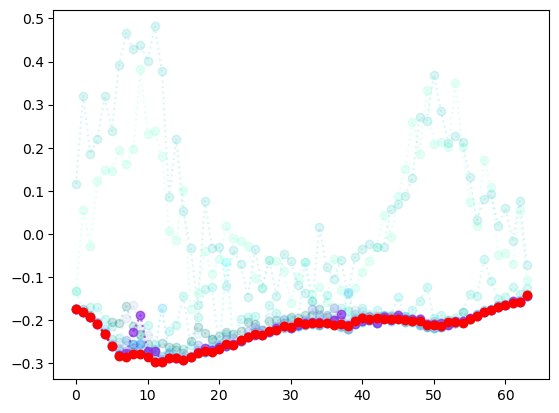

In [69]:
# plot the node features of explainee node and the nodes in the counterfactual graph:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
horizontal = range(len(data_x_node_feat[node_idx]))

# the rest of the nodes on the CE subgraph are plotted with blue-ish colours, transparent
colors = ["aquamarine", "turquoise", "lightseagreen", "mediumturquoise", "paleturquoise", "teal", "aqua", "powderblue",
          "deepskyblue", "skyblue", "dodgerblue", "royalblue", "lavender", "slateblue", "lightsteelblue", "blue",
          "darkblue", "cornflowerblue", "lightskyblue", "cadetblue"]
for i, item in enumerate(optimal_ce_sgraph[0]):
    if int(item) == int(optimal_ce_node):
        continue
    ax.plot(horizontal, data_x_node_feat[item], 'o:', color=colors[i], alpha=0.2)

# the CE node (the node whose 1-hop complete subgraph forms the CE subgraph) features are plotted with colour blueviolet, non-transparent
ax.plot(horizontal, data_x_node_feat[optimal_ce_node], 'o:', color="blueviolet", alpha=0.7)

# input node features are plotted with colour red, non-transparent
ax.plot(horizontal, data_x_node_feat[node_idx], 'or:')

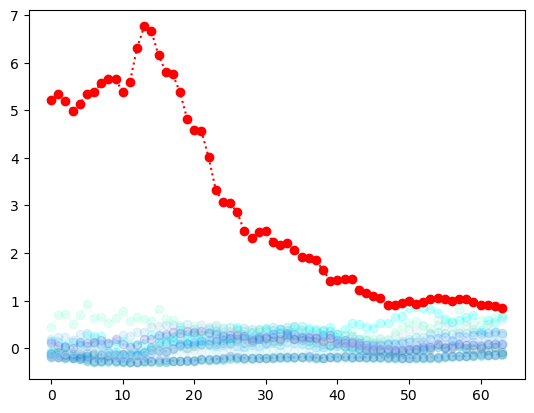

In [64]:
# plot the node features of explainee grah
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
horizontal = range(len(data_x_node_feat[node_idx]))

# the rest of the nodes on the CE subgraph are plotted with blue-ish colours, transparent
colors = ["aquamarine", "turquoise", "lightseagreen", "mediumturquoise", "paleturquoise", "teal", "aqua", "powderblue",
          "deepskyblue", "skyblue", "dodgerblue", "royalblue", "lavender", "slateblue", "lightsteelblue", "blue",
          "darkblue", "cornflowerblue", "lightskyblue", "cadetblue"]
for i, item in enumerate(explainee_sgraph[0]):
    if int(item) == int(node_idx):
        continue
    ax.plot(horizontal, data_x_node_feat[item], 'o:', color=colors[i], alpha=0.2)

# input node features are plotted with colour red, non-transparent
ax.plot(horizontal, data_x_node_feat[node_idx], 'or:')